##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [152]:
#%pip install pandas 
#%pip install matplotlib
#%pip install statsmodels
#%pip install seaborn
#%pip install scikit-learn
#%pip install mlxtend
#%pip install numpy
#%pip install xgboost
#%pip install catboost
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [116]:
# Import packages
import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import xgboost as xgb
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import zscore
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings

filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

## 1. Processing Data

#### 1.A Percentage of Missing Values in Each Column

In [83]:
df1 = pd.read_csv(filepath)
df1.isna().sum() / len(df1) * 100

LATITUDE                                 0.411212
LONGITUDE                                0.411212
AccountID                                0.000000
Company                                  0.000000
SIC Code                                 0.000000
Industry                                 0.000000
8-Digit SIC Code                         0.000000
8-Digit SIC Description                  0.000000
Year Found                               1.487218
Entity Type                              0.000000
Parent Company                           1.761360
Parent Country                           1.781920
Ownership Type                           0.000000
Company Description                      0.000000
Square Footage                         100.000000
Company Status (Active/Inactive)         0.000000
Employees (Single Site)                 42.502227
Employees (Domestic Ultimate Total)      0.270715
Employees (Global Ultimate Total)        9.505860
Sales (Domestic Ultimate Total USD)      0.000000


#### 1.B Correlation and Description

In [84]:
numerical_df = df1.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix
corr_matrix = numerical_df.corr()

# Change it to a DataFrame
corr_m = pd.DataFrame(corr_matrix)

corr_m

,LATITUDE,LONGITUDE,SIC Code,8-Digit SIC Code,Year Found,Square Footage,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Is Domestic Ultimate,Is Global Ultimate
LATITUDE,1.000000,-0.048014,-0.086447,-0.086741,-0.023920,NaN,0.001218,0.004256,-0.010028,0.004602,-0.010685,-0.004247,-0.039308
LONGITUDE,-0.048014,1.000000,0.027467,0.027591,-0.008341,NaN,-0.006147,0.013906,0.003871,-0.006884,0.008687,0.001314,0.009406
SIC Code,-0.086447,0.027467,1.000000,0.999772,0.195683,NaN,-0.050296,-0.022058,0.001587,-0.011493,-0.014743,0.016096,0.087371
8-Digit SIC Code,-0.086741,0.027591,0.999772,1.000000,0.195632,NaN,-0.051988,-0.022178,0.001607,-0.011480,-0.014717,0.015921,0.087409
Year Found,-0.023920,-0.008341,0.195683,0.195632,1.000000,NaN,-0.060472,-0.046540,-0.025981,0.014523,-0.021591,0.076785,0.111644
Square Footage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Employees (Single Site),0.001218,-0.006147,-0.050296,-0.051988,-0.060472,NaN,1.000000,0.139117,0.008463,0.003556,0.001529,-0.016421,0.004828
Employees (Domestic Ultimate Total),0.004256,0.013906,-0.022058,-0.022178,-0.046540,NaN,0.139117,1.000000,0.020404,0.016907,0.024359,-0.060550,-0.044336
Employees (Global Ultimate Total),-0.010028,0.003871,0.001587,0.001607,-0.025981,NaN,0.008463,0.020404,1.000000,-0.003966,0.663478,0.076545,-0.087329
Sales (Domestic Ultimate Total USD),0.004602,-0.006884,-0.011493,-0.011480,0.014523,NaN,0.003556,0.016907,-0.003966,1.000000,0.098110,-0.054561,-0.039314


In [541]:
df1.describe()

,LATITUDE,LONGITUDE,SIC Code,8-Digit SIC Code,Year Found,Square Footage,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Is Domestic Ultimate,Is Global Ultimate
count,29062.000000,29062.000000,29182.000000,2.918200e+04,28748.000000,0.0,16779.000000,29103.000000,2.640800e+04,2.918200e+04,2.918200e+04,29182.000000,29182.000000
mean,1.320677,103.843324,6169.271160,6.169092e+07,2004.505913,NaN,36.856189,139.764182,6.994665e+03,7.520992e+08,3.931771e+09,0.500069,0.257248
std,0.043740,0.053757,1705.845535,1.705778e+07,13.464238,NaN,173.334420,1118.939249,4.539462e+04,1.019636e+10,2.184589e+10,0.500009,0.437125
min,1.238792,103.611319,132.000000,1.320000e+06,1819.000000,NaN,1.000000,1.000000,1.000000e+00,-1.502631e+08,1.000000e+00,0.000000,0.000000
25%,1.284665,103.831874,5084.000000,5.084000e+07,1997.000000,NaN,10.000000,4.000000,4.000000e+00,1.026308e+06,1.026308e+06,0.000000,0.000000
50%,1.309701,103.848989,6719.000000,6.719000e+07,2008.000000,NaN,16.000000,16.000000,1.500000e+01,2.606644e+06,3.259582e+06,1.000000,0.000000
75%,1.337889,103.865922,7311.000000,7.311000e+07,2014.000000,NaN,29.000000,60.000000,1.000000e+02,2.176969e+07,1.482258e+08,1.000000,1.000000
max,1.469800,104.003218,9721.000000,9.721990e+07,2023.000000,NaN,12000.000000,80000.000000,2.190000e+06,3.184764e+11,5.140000e+11,1.000000,1.000000


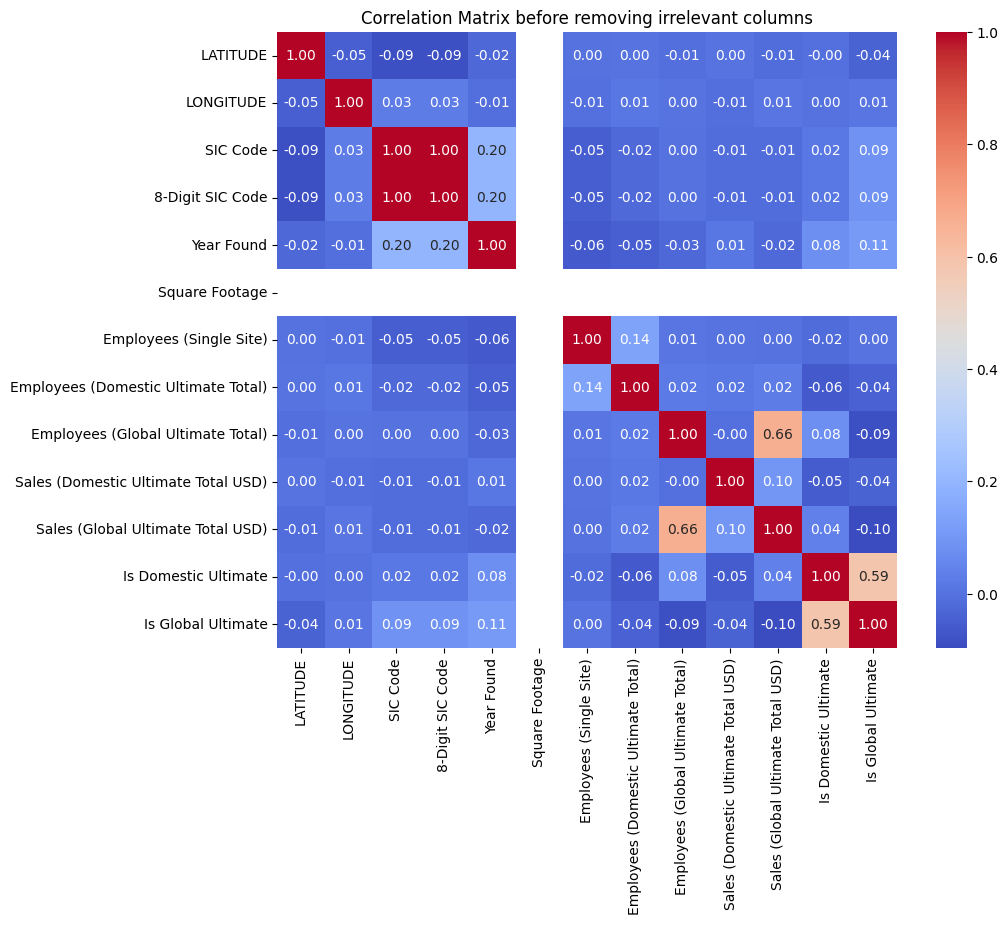

In [542]:
# Plot the correlation matrix

numeric_columns = df1.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df1[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix before removing irrelevant columns')
plt.show()

numeric_columns = df1.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df1[numeric_columns].corr()

#### 1.C Dropping Irrelevant Features

In [85]:
df_1c = df1.copy()
def drop_irrelevant_features(df):
    variables_to_remove = [
        'AccountID', 'Company', '8-Digit SIC Code',
        'Parent Country', 'Domestic Ultimate Company',
        '8-Digit SIC Description', 'Company Status (Active/Inactive)',
        'Fiscal Year End', 'Global Ultimate Company',
        'Global Ultimate Country','Parent Company', 'Industry', 'Square Footage'
    ]

    return df.drop(variables_to_remove, axis=1)
df_1c = drop_irrelevant_features(df_1c)
print(df_1c.isna().sum() / len(df_1c) * 100)

LATITUDE                                0.411212
LONGITUDE                               0.411212
SIC Code                                0.000000
Year Found                              1.487218
Entity Type                             0.000000
Ownership Type                          0.000000
Company Description                     0.000000
Employees (Single Site)                42.502227
Employees (Domestic Ultimate Total)     0.270715
Employees (Global Ultimate Total)       9.505860
Sales (Domestic Ultimate Total USD)     0.000000
Sales (Global Ultimate Total USD)       0.000000
Import/Export Status                   77.338770
Is Domestic Ultimate                    0.000000
Is Global Ultimate                      0.000000
dtype: float64


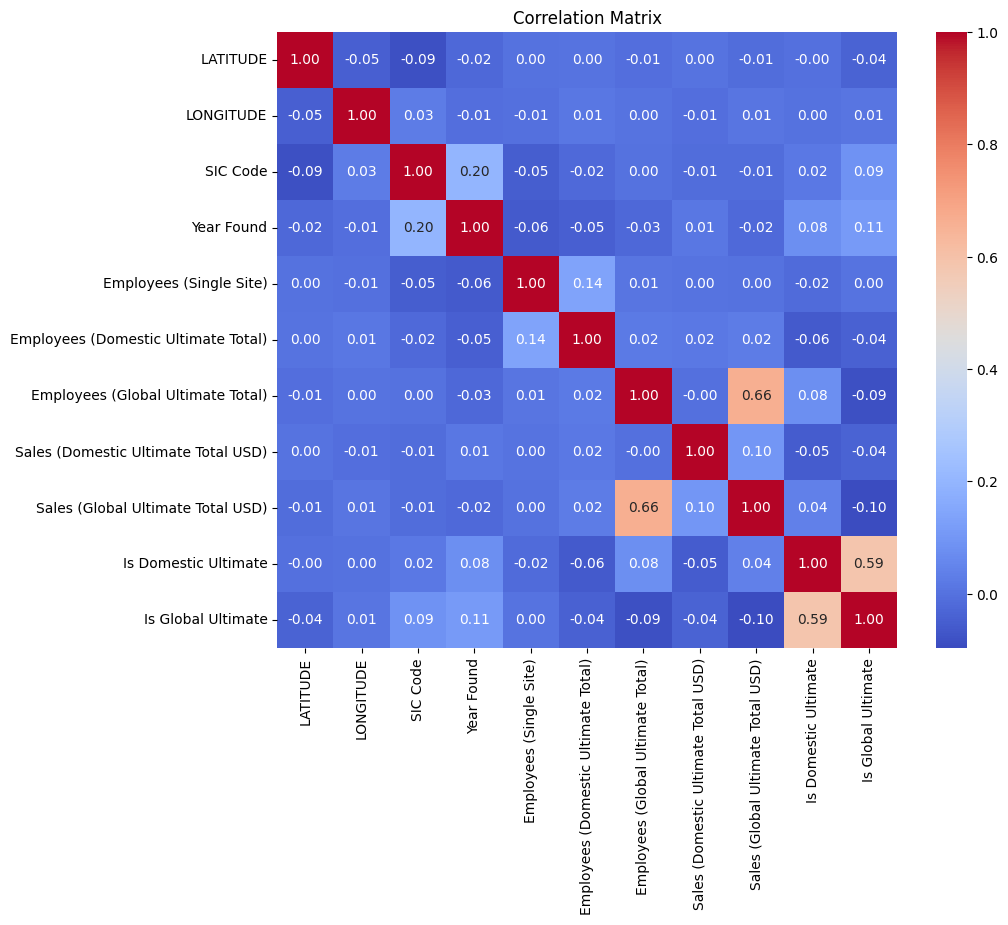

In [544]:
numeric_columns = df_1c.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_1c[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 2. One-Hot Encoding and Imputation 

#### 2.A Binning 'SIC Code' into categories and creation of new column 'Industrys'

In [86]:
# Convert SIC Code into Industrys and add a new column to the df_2a
df_2a = df_1c.copy()

def map_to_industry(sic_code):
    industry_mapping = {
    (101, 999): 'Agriculture',
    (1002, 1499): 'Mining',
    (1500, 1799): 'Construction',
    (2000, 3999): 'Manufacturing',
    (4000, 4999): 'Transportation',
    (5000, 5199): 'Wholesales',
    (5200, 5999): 'Retail',
    (6000, 6799): 'Finance',
    (7000, 8999): 'Services',
    (9000, 9899): 'Public',
    (9900, 10000): 'Others'
    }
    for code_range, industry in industry_mapping.items():
        if code_range[0] < sic_code <= code_range[1]:
            return industry
    return 'Other'

# Create a new column 'Industrys' based on the mapping
def create_industry(df):
    df['Industrys'] = df['SIC Code'].map(map_to_industry)
    df.drop('SIC Code',axis=1)
    return df

df_2a = create_industry(df_2a)
df_2a.head(5)

,LATITUDE,LONGITUDE,SIC Code,Year Found,Entity Type,Ownership Type,Company Description,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Import/Export Status,Is Domestic Ultimate,Is Global Ultimate,Industrys
0,1.285495,103.843852,7361.0,2020.0,Subsidiary,Private,Frank Consulting Services Private Limited is p...,15.0,25.0,NaN,2.209224e+06,4.637871e+06,NaN,0.0,0.0,Services
1,1.291294,103.827476,4449.0,2015.0,Subsidiary,Private,New Desert Orchid Shipping Pte. Ltd. is primar...,39.0,100.0,100.0,7.093536e+09,7.093536e+09,NaN,0.0,0.0,Transportation
2,1.300144,103.857517,6719.0,1993.0,Subsidiary,Private,2Mbao Biocellbank Pte. Ltd. is primarily engag...,4.0,4.0,4.0,1.026308e+06,1.026308e+06,NaN,1.0,0.0,Finance
3,1.300785,103.791263,6719.0,2006.0,Subsidiary,Private,Newbloom Pte. Ltd. is primarily engaged in hol...,10.0,100.0,100.0,7.339898e+10,7.339898e+10,NaN,0.0,0.0,Finance
4,1.298759,103.859430,6719.0,2006.0,Parent,Private,Asia Green Capital Pte. Ltd. is primarily enga...,NaN,4.0,4.0,4.322130e+05,4.322130e+05,Exports,1.0,1.0,Finance


##### 2.A.1 Graph Sales (Domestic Ultimate Total USD) by Industrys

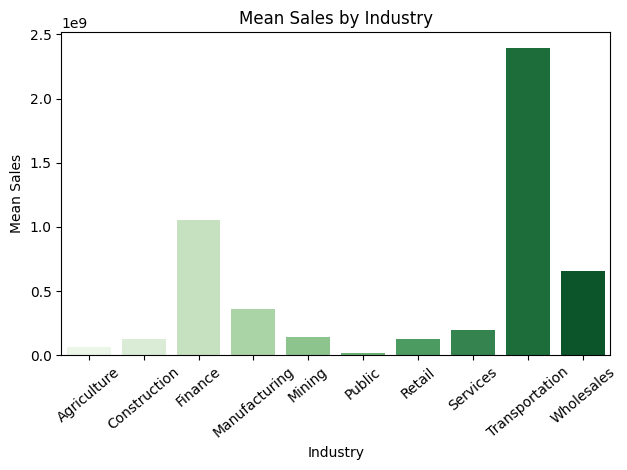

In [122]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Plot Mean Sales (Domestic Ultimate Total USD) vs Industrys
mean_sales = df_2a.groupby('Industrys')['Sales (Domestic Ultimate Total USD)'].mean().reset_index()
sns.barplot(x='Industrys', y='Sales (Domestic Ultimate Total USD)', data=mean_sales, palette='Greens')
plt.xticks(rotation = 40)
plt.xlabel('Industry')
plt.ylabel('Mean Sales')
plt.title('Mean Sales by Industry')
plt.tight_layout()

#### 2.B Imputation of Import/Export

##### 2.B.1 Imputation of Import/Export Based on Company Description using NLP 

In [92]:
df_2b = df_2a.copy()

def impute_and_evaluate_import_export_status(df, text_column, target_column):
    # Initialize a label encoder
    import_label_encoder = LabelEncoder()

    # Encode the non-missing values of the target column
    non_missing_mask = df[target_column].notna()
    encoded_labels = import_label_encoder.fit_transform(df.loc[non_missing_mask, target_column])

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        df.loc[non_missing_mask, [text_column]], 
        encoded_labels, 
        test_size=0.2, 
        random_state=42
    )
    
    # Text preprocessing and vectorization pipeline
    text_preprocessing_pipeline = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(stop_words='english'))
    ])
    
    # Full preprocessing pipeline (could include other transformers if needed)
    preprocessor = ColumnTransformer(
        transformers=[
            ('text_preprocessing', text_preprocessing_pipeline, text_column),
        ]
    )
    
    # Model pipeline
    model_pipeline = make_pipeline(preprocessor, RandomForestClassifier(random_state=42))
    
    # Train the model
    model_pipeline.fit(X_train, y_train)
    
    # Predict on the test set and evaluate the accuracy
    y_pred = model_pipeline.predict(X_test)
    y_pred_labels = import_label_encoder.inverse_transform(y_pred)
    
    # Post-processing step to assign 'neither' category
    y_pred_proba = model_pipeline.predict_proba(X_test)
    prob_threshold = 0.8  # Define a threshold for the maximum probability to assign 'neither'
    y_pred_post_processed = [label if max(proba) >= prob_threshold else 'Neither' for label, proba in zip(y_pred_labels, y_pred_proba)]
    
    # Evaluate the accuracy after post-processing
    y_test_labels = import_label_encoder.inverse_transform(y_test)
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    print(f"Accuracy on the test set with post-processing: {accuracy * 100:.2f}%")
    print(classification_report(y_test_labels, y_pred_post_processed, zero_division=1))

    # Impute missing values with post-processing
    missing_mask = df[target_column].isna()
    if missing_mask.any():
        predictions_for_missing = model_pipeline.predict(df.loc[missing_mask, [text_column]])
        probas_for_missing = model_pipeline.predict_proba(df.loc[missing_mask, [text_column]])
        
        imputed_values = [import_label_encoder.classes_[np.argmax(p)] if max(p) >= prob_threshold else 'Neither' for p in probas_for_missing]
        df.loc[missing_mask, target_column] = imputed_values
    
    # Return the dataframe with imputed values and the accuracy
    return df, accuracy, model_pipeline, import_label_encoder



#'Company Description' is the text column, and 'Import/Export Status' is the target column
before_counts = df_2b['Import/Export Status'].value_counts(dropna=False)
print("Counts before imputation:")
print(before_counts)

df_2b, model_accuracy, import_export_imputation_model, import_label_encoder = impute_and_evaluate_import_export_status(df_2b, 'Company Description', 'Import/Export Status')
print(f"The model's accuracy is {model_accuracy * 100:.2f}%")
print(model_accuracy)

after_counts = df_2b['Import/Export Status'].value_counts(dropna=False)
print("\nCounts after imputation:")
print(after_counts)

## Function for pre-processsing once model is trained
def impute_import_export_status(df, model, text_column, target_column, label_encoder, prob_threshold=0.8):
    # Check for missing values
    before_counts = df['Import/Export Status'].value_counts(dropna=False)
    # print("Counts before imputation:")
    # print(before_counts)

    missing_mask = df[target_column].isna()
    if missing_mask.any():
        # Predict probabilities
        probas = model.predict_proba(df.loc[missing_mask, [text_column]])
        # Predict labels
        predictions = [label_encoder.classes_[np.argmax(p)] if max(p) >= prob_threshold else 'Neither' for p in probas]
        # Impute values
        df.loc[missing_mask, target_column] = predictions
    after_counts = df['Import/Export Status'].value_counts(dropna=False)
    # print("\nCounts after imputation:")
    # print(after_counts)
    return df

Counts before imputation:
Import/Export Status
NaN                       22569
Both Imports & Exports     4254
Exports                    1681
Imports                     678
Name: count, dtype: int64
Accuracy on the test set with post-processing: 68.86%
                        precision    recall  f1-score   support

Both Imports & Exports       0.83      0.62      0.71       844
               Exports       0.69      0.23      0.34       342
               Imports       0.38      0.02      0.04       137
               Neither       0.00      1.00      0.00         0

              accuracy                           0.45      1323
             macro avg       0.47      0.47      0.27      1323
          weighted avg       0.74      0.45      0.54      1323

The model's accuracy is 68.86%
0.6885865457294029

Counts after imputation:
Import/Export Status
Neither                   16457
Both Imports & Exports     7377
Exports                    4511
Imports                     837
Name:

#### 2.C Imputation of Missing Values for Employees (Domestic Ultimate Total)

##### 2.C.1 Exploring Relationship between Employees (Domestic Ultimate Total) and Employees (Single Site)

count    29103.000000
mean       139.764182
std       1118.939249
min          1.000000
25%          4.000000
50%         16.000000
75%         60.000000
max      80000.000000
Name: Employees (Domestic Ultimate Total), dtype: float64
Axes(0.125,0.11;0.775x0.77)
                                     Employees (Domestic Ultimate Total)  \
Employees (Domestic Ultimate Total)                             1.000000   
Employees (Single Site)                                         0.139117   

                                     Employees (Single Site)  
Employees (Domestic Ultimate Total)                 0.139117  
Employees (Single Site)                             1.000000  
                                     Employees (Domestic Ultimate Total)  \
Employees (Domestic Ultimate Total)                             1.000000   
Sales (Domestic Ultimate Total USD)                             0.016907   

                                     Sales (Domestic Ultimate Total USD)  
Employees (Domes

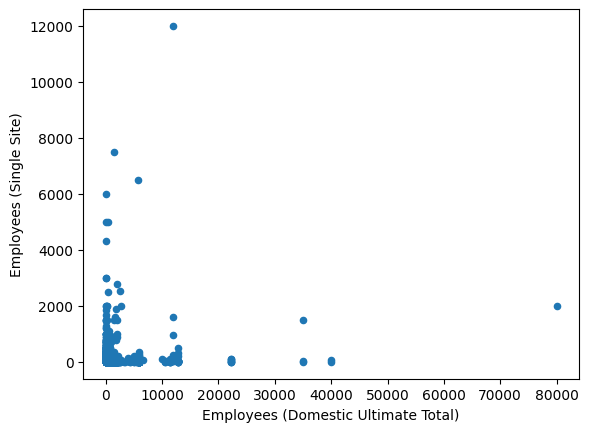

In [94]:
print(df_2b['Employees (Domestic Ultimate Total)'].describe()) #mean = 139.764182

print(df_2b.plot.scatter(x = 'Employees (Domestic Ultimate Total)', y = 'Employees (Single Site)'))

print(df_2b[['Employees (Domestic Ultimate Total)', 'Employees (Single Site)']].corr())
print(df_2b[['Employees (Domestic Ultimate Total)', 'Sales (Domestic Ultimate Total USD)']].corr())

##### 2.C.2 Exploring Relationship between Employees (Domestic Ultimate Total) and Sales (Domestic Ultimate Total USD)

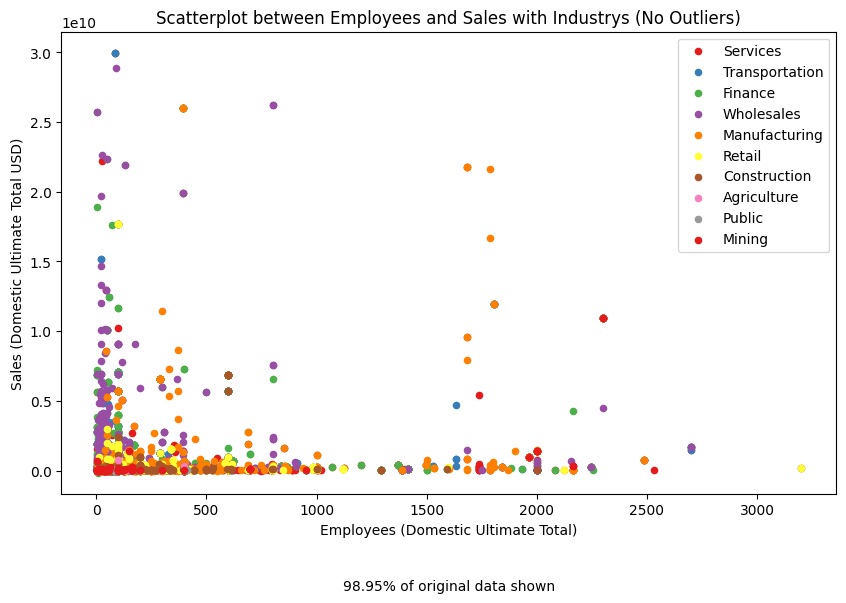

In [95]:
#ScatterPlot for 'Employees' vs 'Sales (Domestic Ultimate Total USD) removed outliers 3 standard deviation away'

# Get unique industries
unique_industries = df_2b['Industrys'].unique()

# Create a dictionary to map each unique industry to a unique color
industry_colors = dict(zip(unique_industries, sns.color_palette('Set1', n_colors=len(unique_industries))))

# Drop rows with missing values in the selected columns
df_filtered = df_2b.dropna(subset=['Employees (Domestic Ultimate Total)', 'Sales (Domestic Ultimate Total USD)'])

# Z-score normalization to identify outliers
z_scores = zscore(df_filtered[['Employees (Domestic Ultimate Total)', 'Sales (Domestic Ultimate Total USD)']])
threshold = 3
filtered_indices = (z_scores < threshold).all(axis=1)
df_no_outliers = df_filtered[filtered_indices]

# Plot the scatterplot without outliers with smaller circles
plt.figure(figsize=(10, 6))
for industry in unique_industries:
    subset = df_no_outliers[df_no_outliers['Industrys'] == industry]
    if not subset.empty:  # Check if there is data for the industry
        color = industry_colors[industry]
        plt.scatter(subset['Employees (Domestic Ultimate Total)'], subset['Sales (Domestic Ultimate Total USD)'], label=industry, color=color, s=20)

# Calculate the percentage of original data shown
percentage_shown = (len(df_no_outliers) / len(df_filtered)) * 100

# Annotate the plot with the percentage at the bottom
plt.text(0.5, -0.2, f'{percentage_shown:.2f}% of original data shown', transform=plt.gca().transAxes, ha='center', va='center')

plt.xlabel('Employees (Domestic Ultimate Total)')
plt.ylabel('Sales (Domestic Ultimate Total USD)')
plt.title('Scatterplot between Employees and Sales with Industrys (No Outliers)')
plt.legend()

plt.show()

##### 2.C.3 Imputation of Missing Values from OLS Regression

In [96]:
df_2c = df_2b.copy()

## Run OLS on Employees (Domestic Ultimate Total) using Emplyees (Single Site)
employees_imputation_model = sm.ols(formula="Q('Employees (Domestic Ultimate Total)') ~ Q('Employees (Single Site)')", data=df_2c).fit()
print(employees_imputation_model.summary())  # Check if results are significant

# Identify indices with missing values in 'Employees (Domestic Ultimate Total)' but not in 'Employees (Single Site)'
missing_indices = df_2c[df_2c['Employees (Domestic Ultimate Total)'].isnull() & df_2c['Employees (Single Site)'].notnull()].index

# Predict missing values using the fitted model
predicted_values = employees_imputation_model.predict(df_2c.loc[missing_indices, ['Employees (Single Site)']])

# Replace missing values with predicted values
df_2c.loc[missing_indices, 'Employees (Domestic Ultimate Total)'] = predicted_values

# Only five rows left where we cannot replace with Employees (Single Site)
remaining_missing = df_2c.loc[df_2c['Employees (Domestic Ultimate Total)'].isna()][['Employees (Single Site)', 'Employees (Domestic Ultimate Total)']]
print(remaining_missing)
df_2c = df_2c[df_2c['Employees (Domestic Ultimate Total)'].notna()]
len(df_2c['Employees (Domestic Ultimate Total)'])


## Function for pre-processsing once model is trained
def impute_employees(df, model):
    missing_indices = df[df['Employees (Domestic Ultimate Total)'].isnull() & df['Employees (Single Site)'].notnull()].index
    if missing_indices.any():
        # Predict missing values
        predicted_values = model.predict(df.loc[missing_indices, ['Employees (Single Site)']])
        # Impute values
        df.loc[missing_indices, 'Employees (Domestic Ultimate Total)'] = predicted_values
    return df


                                       OLS Regression Results                                       
Dep. Variable:     Q('Employees (Domestic Ultimate Total)')   R-squared:                       0.019
Model:                                                  OLS   Adj. R-squared:                  0.019
Method:                                       Least Squares   F-statistic:                     329.6
Date:                                      Mon, 29 Jan 2024   Prob (F-statistic):           5.79e-73
Time:                                              23:13:10   Log-Likelihood:            -1.4246e+05
No. Observations:                                     16705   AIC:                         2.849e+05
Df Residuals:                                         16703   BIC:                         2.849e+05
Df Model:                                                 1                                         
Covariance Type:                                  nonrobust                                

#### 2.D Imputation of Missing Values for 'Year Found'

In [97]:
df_2d = df_2c.copy()
print(df_2d['Year Found'].describe())

## Replace missing values in Year Found by the median 2008 
df_2d['Year Found'] = df_2d['Year Found'].fillna(2008)

print(df_2d[['Year Found', 'Sales (Domestic Ultimate Total USD)']].corr())

result = sm.ols(formula="df_2d['Sales (Domestic Ultimate Total USD)'] ~ df_2d['Year Found']", data=df_2d).fit()
print(result.summary()) #Significant 

count    28743.000000
mean      2004.507706
std         13.462817
min       1819.000000
25%       1997.000000
50%       2008.000000
75%       2014.000000
max       2023.000000
Name: Year Found, dtype: float64
                                     Year Found  \
Year Found                             1.000000   
Sales (Domestic Ultimate Total USD)    0.014328   

                                     Sales (Domestic Ultimate Total USD)  
Year Found                                                      0.014328  
Sales (Domestic Ultimate Total USD)                             1.000000  
                                         OLS Regression Results                                         
Dep. Variable:     df_2d['Sales (Domestic Ultimate Total USD)']   R-squared:                       0.000
Model:                                                      OLS   Adj. R-squared:                  0.000
Method:                                           Least Squares   F-statistic:                   

##### 2.D.1 Time Series Analysis

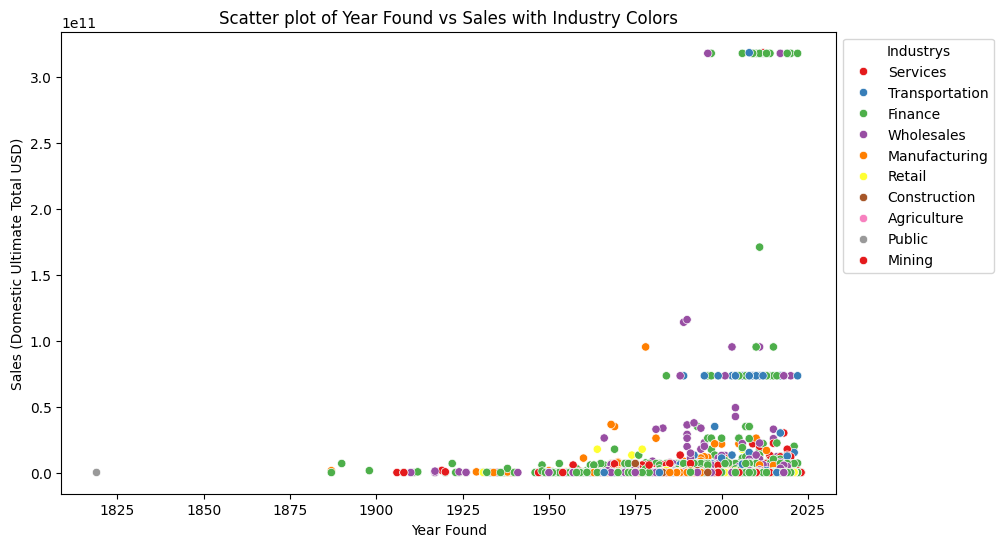

In [98]:
# Create a dictionary to map each unique industry to a unique color
industry_palette = sns.color_palette('Set1', n_colors=len(df_2d['Industrys'].unique()))
industry_colors = dict(zip(df_2d['Industrys'].unique(), industry_palette))

# Scatter plot for 'Year Found' vs 'Sales' with colors based on industries
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year Found', y='Sales (Domestic Ultimate Total USD)', hue='Industrys', palette=industry_colors, data=df_2d)
plt.title('Scatter plot of Year Found vs Sales with Industry Colors')
plt.legend(title='Industrys', bbox_to_anchor=(1, 1))
plt.show()


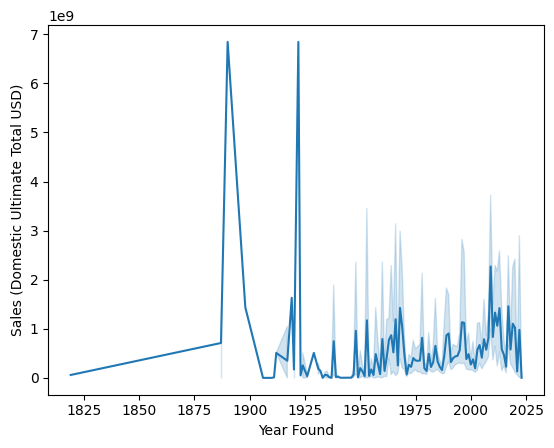

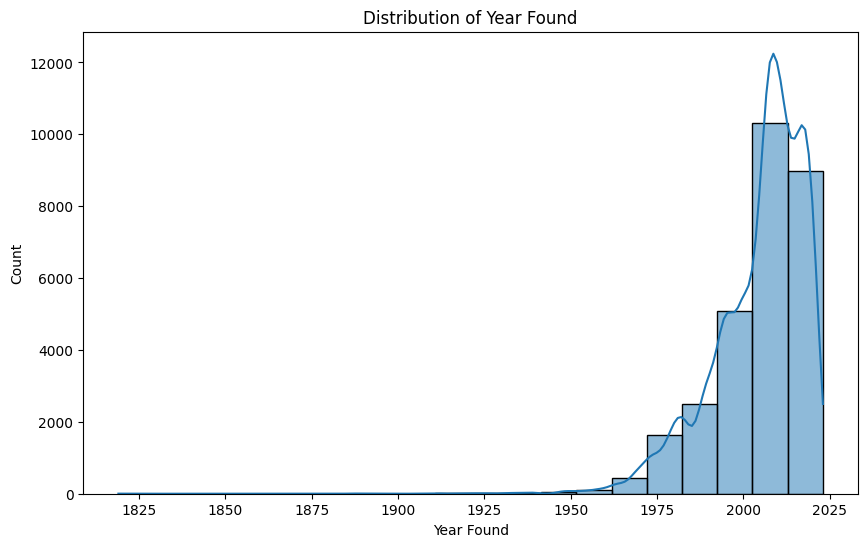

In [101]:
sns.lineplot(x='Year Found', y='Sales (Domestic Ultimate Total USD)', data=df_2d)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_2d['Year Found'], bins=20, kde=True)
plt.title('Distribution of Year Found')
plt.show()

#### 2.E One-Hot Encoding for Entity Type, Ownership Type, and Industrys


In [102]:
df_2e = df_2d.copy()
print(df_2e)
# df_2e = df_2e.drop(['Sales (Domestic Ultimate Total USD)'],axis=1)

def one_hot_encoding(df):
    df=pd.get_dummies(df, columns=['Industrys'],drop_first=True)
    df=pd.get_dummies(df, columns=['Entity Type'],drop_first=True)
    df=pd.get_dummies(df, columns=['Ownership Type'],drop_first=True)
    df=pd.get_dummies(df, columns=['Import/Export Status'],drop_first=True)
    return df

df_2e = one_hot_encoding(df_2e)

print(df_2e)

       LATITUDE   LONGITUDE  SIC Code  Year Found  Entity Type Ownership Type  \
0      1.285495  103.843852    7361.0      2020.0   Subsidiary        Private   
1      1.291294  103.827476    4449.0      2015.0   Subsidiary        Private   
2      1.300144  103.857517    6719.0      1993.0   Subsidiary        Private   
3      1.300785  103.791263    6719.0      2006.0   Subsidiary        Private   
4      1.298759  103.859430    6719.0      2006.0       Parent        Private   
...         ...         ...       ...         ...          ...            ...   
29177  1.355309  103.887857    6719.0      2009.0   Subsidiary        Private   
29178  1.319605  103.898298    6719.0      2008.0  Independent        Private   
29179  1.316363  103.924303    6726.0      1991.0   Subsidiary         Public   
29180  1.295595  103.858968    6719.0      2018.0   Subsidiary        Private   
29181  1.311769  103.801710    5099.0      2018.0   Subsidiary        Private   

                           

##### 2.E.1 Mean Sales (Domestic Ultimate Total USD) Across Entity Types and Ownership Types

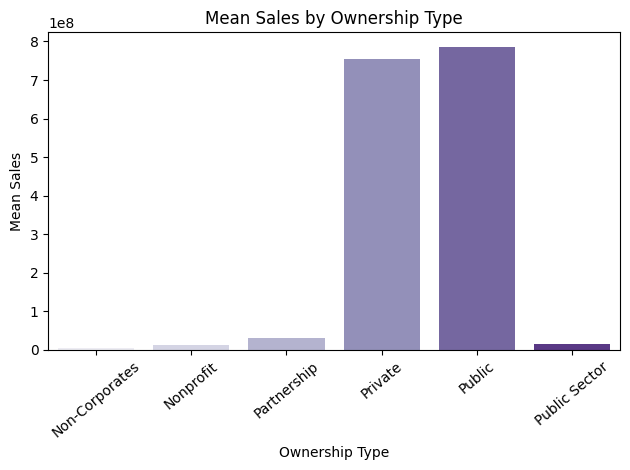

In [123]:
warnings.filterwarnings("ignore", category=FutureWarning)
# Plot Mean Sales (Domestic Ultimate Total USD) vs Entity Type
mean_sales2 = df_2d.groupby('Ownership Type')['Sales (Domestic Ultimate Total USD)'].mean().reset_index()
sns.barplot(x=mean_sales2['Ownership Type'],y=mean_sales2['Sales (Domestic Ultimate Total USD)'],palette='Purples')
plt.xticks(rotation = 40)
plt.xlabel('Ownership Type')
plt.ylabel('Mean Sales')
plt.title('Mean Sales by Ownership Type')
plt.tight_layout()

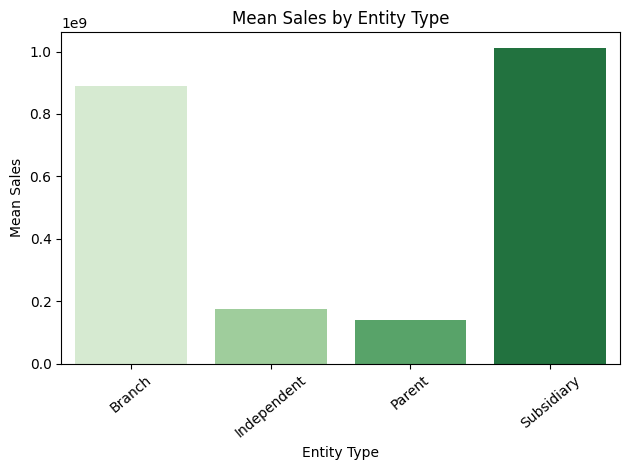

In [125]:
warnings.filterwarnings("ignore", category=FutureWarning)
# Plot Mean Sales (Domestic Ultimate Total USD) vs Entity Type
mean_sales = df_2d.groupby('Entity Type')['Sales (Domestic Ultimate Total USD)'].mean().reset_index()
sns.barplot(x=mean_sales['Entity Type'],y=mean_sales['Sales (Domestic Ultimate Total USD)'],palette = 'Greens')
plt.xticks(rotation = 40)
plt.xlabel('Entity Type')
plt.ylabel('Mean Sales')
plt.title('Mean Sales by Entity Type')
plt.tight_layout()

#### 2.F Final Cleaning of Data

In [126]:
df_2f = df_2e.copy()

def final_cleaning(df):
    variables_to_remove = [
        'Company Description'
    ]
    df = df.drop(variables_to_remove, axis=1)
    return df

df_2f = final_cleaning(df_2f)
print("Before Dropping:" + "\n" + str(df_2f.isna().sum() / len(df_2f) * 100))
df_2f = df_2f.dropna()
print("After Dropping:" + "\n" + str(df_2f.isna().sum() / len(df_2f) * 100))
print("Number of data points:" + str(len(df_2f)))
print(df_2f.columns)
print(df_2f.shape)
df_2f.head(5)

Before Dropping:
LATITUDE                                0.411283
LONGITUDE                               0.411283
SIC Code                                0.000000
Year Found                              0.000000
Employees (Single Site)                42.492374
Employees (Domestic Ultimate Total)     0.000000
Employees (Global Ultimate Total)       9.497207
Sales (Domestic Ultimate Total USD)     0.000000
Sales (Global Ultimate Total USD)       0.000000
Is Domestic Ultimate                    0.000000
Is Global Ultimate                      0.000000
Industrys_Construction                  0.000000
Industrys_Finance                       0.000000
Industrys_Manufacturing                 0.000000
Industrys_Mining                        0.000000
Industrys_Public                        0.000000
Industrys_Retail                        0.000000
Industrys_Services                      0.000000
Industrys_Transportation                0.000000
Industrys_Wholesales                    0.000000
Ent

,LATITUDE,LONGITUDE,SIC Code,Year Found,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Is Domestic Ultimate,...,Entity Type_Parent,Entity Type_Subsidiary,Ownership Type_Nonprofit,Ownership Type_Partnership,Ownership Type_Private,Ownership Type_Public,Ownership Type_Public Sector,Import/Export Status_Exports,Import/Export Status_Imports,Import/Export Status_Neither
1,1.291294,103.827476,4449.0,2015.0,39.0,100.0,100.0,7.093536e+09,7.093536e+09,0.0,...,False,True,False,False,True,False,False,False,False,True
2,1.300144,103.857517,6719.0,1993.0,4.0,4.0,4.0,1.026308e+06,1.026308e+06,1.0,...,False,True,False,False,True,False,False,False,False,True
3,1.300785,103.791263,6719.0,2006.0,10.0,100.0,100.0,7.339898e+10,7.339898e+10,0.0,...,False,True,False,False,True,False,False,False,False,True
5,1.444773,103.812740,4959.0,1986.0,300.0,4.0,4.0,1.026308e+06,1.026308e+06,0.0,...,False,True,False,False,True,False,False,False,False,True
7,1.282887,103.850849,6719.0,2010.0,10.0,4.0,4.0,1.026308e+06,1.026308e+06,0.0,...,False,True,False,False,True,False,False,False,False,True


## 3. Model Training

In [127]:
df_3 = df_2f.copy()

# Defining predictors and target variable
y = df_3['Sales (Domestic Ultimate Total USD)']
X = df_3.drop('Sales (Domestic Ultimate Total USD)', axis = 1)


print(X)
# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


       LATITUDE   LONGITUDE  SIC Code  Year Found  Employees (Single Site)  \
1      1.291294  103.827476    4449.0      2015.0                     39.0   
2      1.300144  103.857517    6719.0      1993.0                      4.0   
3      1.300785  103.791263    6719.0      2006.0                     10.0   
5      1.444773  103.812740    4959.0      1986.0                    300.0   
7      1.282887  103.850849    6719.0      2010.0                     10.0   
...         ...         ...       ...         ...                      ...   
29171  1.274915  103.799145    6719.0      2020.0                     10.0   
29175  1.292221  103.850613    7389.0      2009.0                     25.0   
29176  1.277753  103.848429    1731.0      1996.0                    100.0   
29180  1.295595  103.858968    6719.0      2018.0                     10.0   
29181  1.311769  103.801710    5099.0      2018.0                     11.0   

       Employees (Domestic Ultimate Total)  Employees (Global U

#### 3.A Linear Regression Model

In [133]:
import sklearn


lr = LinearRegression()
# Fit the model with selected features
lr.fit(X_train, y_train)

# Make predictions using your trained model
y_pred = lr.predict(X_test)

# Calculate metrics
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
rss = np.sum((y_pred-y_test)**2)
n = len(y_test)
aic = n*np.log(rss/n) + 2*len(X_test.columns)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Akaike Information Criterion (AIC): {aic}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 1659747533.8952503
Mean Squared Error (MSE): 4.5986362370063e+19
Akaike Information Criterion (AIC): 198454.50906931184
Root Mean Squared Error (RMSE): 6781324529.180343
R-squared (R2): 0.037226288349268


#### 3.B Gradient Boosting

In [129]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor

model1 = GradientBoostingRegressor(random_state=42)

# Use k-fold cross-validation with 10 folds
gradient_boost_model = GradientBoostingRegressor(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get R-squared scores
cv_scores = cross_val_score(model1, X_train, y_train, cv=kf, scoring='r2')

# Print the R-squared scores for each fold
print("Cross-Validation R-squared scores:", cv_scores)

# Print the mean and standard deviation of the R-squared scores
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Train the model on the entire training set
gradient_boost_model.fit(X_train, y_train)

# Evaluate the model on the test set
test_score = gradient_boost_model.score(X_test, y_test)
print("Test R-squared score:", test_score)

Cross-Validation R-squared scores: [ 0.26560934  0.2963767   0.13566476  0.5221853   0.36860544  0.27329639
  0.66251876  0.64409115  0.32919778 -0.01669885]
Mean R-squared score: 0.3480846761040147
Standard Deviation of R-squared scores: 0.20269087142321998
Test R-squared score: 0.7273425978697006


#### 3.C XG-Boost


In [134]:
model2 = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=3)
model2.fit(X_train, y_train)


# Use k-fold cross-validation with 10 folds
xg_boost_model = xgb.XGBRegressor(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get R-squared scores
cv_scores = cross_val_score(model2, X_train, y_train, cv=kf, scoring='r2')

# Print the R-squared scores for each fold
print("Cross-Validation R-squared scores:", cv_scores)

# Print the mean and standard deviation of the R-squared scores
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Train the model on the entire training set
xg_boost_model.fit(X_train, y_train)

# Evaluate the model on the test set
test_score = xg_boost_model.score(X_test, y_test)
print("Test R-squared score:", test_score)

Cross-Validation R-squared scores: [ 0.30102468  0.18457286  0.27650854  0.36584246 -0.12277137 -0.29205982
  0.77374134  0.64279929  0.12779372  0.31062184]
Mean R-squared score: 0.2568073534621541
Standard Deviation of R-squared scores: 0.30008931964506647
Test R-squared score: 0.6548119846799585


#### 3.D Catboost

In [135]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from catboost import CatBoostRegressor

# Initialize the CatBoost Regressor
model3 = CatBoostRegressor(random_state=42)

# Use k-fold cross-validation with 10 folds
cat_boost_model = CatBoostRegressor(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get R-squared scores
cv_scores = cross_val_score(model3, X_train, y_train, cv=kf, scoring='r2')

# Print the R-squared scores for each fold
print("Cross-Validation R-squared scores:", cv_scores)

# Print the mean and standard deviation of the R-squared scores
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Train the model on the entire training set
cat_boost_model.fit(X_train, y_train)

# Evaluate the model on the test set
test_score = cat_boost_model.score(X_test, y_test)
print("Test R-squared score:", test_score)


Learning rate set to 0.058138
0:	learn: 11534432046.7225838	total: 2.44ms	remaining: 2.44s
1:	learn: 11423693266.6752014	total: 4.03ms	remaining: 2.01s
2:	learn: 11312881745.1109028	total: 5.6ms	remaining: 1.86s
3:	learn: 11089984988.0717659	total: 7.04ms	remaining: 1.75s
4:	learn: 11013013521.1175938	total: 8.34ms	remaining: 1.66s
5:	learn: 10909179313.0442677	total: 9.68ms	remaining: 1.6s
6:	learn: 10663364333.0099754	total: 10.9ms	remaining: 1.55s
7:	learn: 10606676839.4709587	total: 12.4ms	remaining: 1.53s
8:	learn: 10532061448.0379925	total: 14.3ms	remaining: 1.58s
9:	learn: 10479629419.4477921	total: 15.9ms	remaining: 1.57s
10:	learn: 10402091773.9680786	total: 17.9ms	remaining: 1.61s
11:	learn: 10347527579.9374542	total: 19.6ms	remaining: 1.61s
12:	learn: 10298342488.0368862	total: 22ms	remaining: 1.67s
13:	learn: 10261365358.9993134	total: 23.4ms	remaining: 1.65s
14:	learn: 10146945722.7091045	total: 24.9ms	remaining: 1.64s
15:	learn: 10101115628.5545845	total: 26.4ms	remaining

## 4. Model Saving

In [136]:
import joblib

# Save the base model to an HDF5 file
joblib.dump(cat_boost_model, 'cat_boost_model.h5')

['cat_boost_model.h5']

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [138]:
import joblib
def load_model():
    return joblib.load('cat_boost_model.h5')

def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = []
    
    # Drop Irrelevant Features
    hidden_data = drop_irrelevant_features(hidden_data)
    
    # Create Industrys column
    hidden_data = create_industry(hidden_data)
    
    # Import/Export Imputation
    hidden_data = impute_import_export_status(hidden_data, import_export_imputation_model, 'Company Description','Import/Export Status', import_label_encoder)
    
    # Employees Imputation
    hidden_data = impute_employees(hidden_data, employees_imputation_model)
    
    ## Year Imputation
    df_2d['Year Found'] = df_2d['Year Found'].fillna(2008)
    
    # One-hot encoding
    hidden_data = one_hot_encoding(hidden_data)
    
    #Final cleaning
    hidden_data = final_cleaning(hidden_data)
    
    cat_boost_model = load_model()
    result = cat_boost_model.predict(hidden_data)
    # print(hidden_data.shape)
    return result

##### Cell to check testing_hidden_data function

In [139]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
actual_values = test_df['Sales (Domestic Ultimate Total USD)'].copy()
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
predictions = testing_hidden_data(test_df)
comparison_df = pd.DataFrame({'Actual': actual_values, 'Predicted': predictions})
print(comparison_df)

negative_count = sum(1 for pred in predictions if pred < 0)
print(f"Number of negative predictions: {negative_count}")

             Actual     Predicted
0      2.209224e+06 -1.206828e+09
1      7.093536e+09  7.257981e+09
2      1.026308e+06 -2.179464e+08
3      7.339898e+10  7.435704e+10
4      4.322130e+05 -1.962746e+09
...             ...           ...
29177  2.949122e+06 -9.737151e+08
29178  1.026308e+06 -1.399773e+08
29179  2.289731e+08 -2.752274e+10
29180  1.026308e+06 -9.551517e+07
29181  1.026308e+06  8.294320e+07

[29182 rows x 2 columns]
Number of negative predictions: 14511


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!